<a href="https://colab.research.google.com/github/MemoOR/Image_classification/blob/main/P_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
try:
  import pillow_heif
except:
  os.system("pip3 install pillow-heif")
  import pillow_heif

In [2]:
import cv2
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from PIL import Image
from skimage import io, filters
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.filters import threshold_otsu
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_opening, binary_closing

In [3]:
directories = ["./drive/MyDrive/img_PF/JPEG/Rock/Img/",
                "./drive/MyDrive/img_PF/JPEG/Paper/Img/",
                "./drive/MyDrive/img_PF/JPEG/Scissors/Img/"]

mask_directories = ["./drive/MyDrive/img_PF/JPEG/Rock/Mask/",
                    "./drive/MyDrive/img_PF/JPEG/Paper/Mask/",
                    "./drive/MyDrive/img_PF/JPEG/Scissors/Mask/"]

def create_photos_from_heic(folder):
  open_dir = "./drive/MyDrive/img_PF"
  heic_dir = open_dir + "/HEIC/" + folder + "/"
  jpeg_dir = open_dir + "/JPEG/" + folder + "/Img/"

  size = 256, 256

  for index, filename in enumerate(os.listdir(heic_dir)):
    image_name = folder + str(index)
    save_name = jpeg_dir + image_name + ".jpg"

    open_file = heic_dir + filename
    heif_file = pillow_heif.open_heif(open_file)

    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
    )
    
    image.thumbnail(size)
    image = image.convert('L')
    image.save(save_name, format="JPEG")   


def create_more_img():  
  for direct in directories:
    number_files = os.listdir(direct)
    for index, filename in enumerate(number_files):
      
      if "Rock" in filename:
        file_type = "Rock"
      elif "Paper" in filename:
        file_type = "Paper"
      else:
        file_type = "Scissors"

      file_count = len(os.listdir(direct))
      open_name = direct + filename
      image = io.imread(open_name)

      for i in range(3):
        save_name = direct + file_type + str(file_count) + ".jpg"
        image = rotate(image, 90, resize=True)
        io.imsave(save_name, image)
        file_count += 1

def create_binary_mask():
  for i, direct in enumerate(directories):
    for index, filename in enumerate(os.listdir(direct)):
      
      if "Rock" in filename:
        file_type = "Rock"
      elif "Paper" in filename:
        file_type = "Paper"
      else:
        file_type = "Scissors"

      open_name = direct + filename
      img = io.imread(open_name)
      thresh_otsu = threshold_otsu(img)
      mask = cv2.threshold(img, thresh_otsu, 255, cv2.THRESH_BINARY)[1]

      new_name = filename.split(".")[0] + "_Mask"
      save_name = mask_directories[i] + new_name + ".jpg"
      io.imsave(save_name, mask)

def create_work_images():
  create_photos_from_heic("Rock")
  create_photos_from_heic("Paper")
  create_photos_from_heic("Scissors")
  create_more_img()

In [4]:
%%capture
# create_work_images()
# create_binary_mask()

In [5]:
def segmentation_thresh(img,thresh):
  #img: imagen
  #thresh: umbral
  img_segmented = np.copy(img)
  img_segmented[img_segmented < thresh] = 0
  img_segmented[img_segmented > thresh] = 1
  return img_segmented

def calc_region_params(img, img_bin, perimetro):
  area = img_bin[img_bin == 1].shape[0]
  compacidad = (perimetro**2)/(area)
  rel_circularidad = (4*np.pi*area)/(perimetro**2)

  region_points = np.where(img_bin == 1)
  region_intensities = np.zeros(len(region_points[0]))
  
  for i in range(len(region_points[0])):
    x = region_points[0][i]
    y = region_points[1][i]
    region_intensities[i] = img[x][y]

  mean_intensity = np.mean(region_intensities)
  var_intensity = np.var(region_intensities)
  suavidad = 1 - (1)/(1+var_intensity)

  return area, perimetro, compacidad, rel_circularidad, mean_intensity, var_intensity, suavidad

In [6]:
def create_data_csv():
  csv_fields = ['area', 'perimetro', 'compacidad',
                'rel_circularidad', 'intensidad_prom',
                'var_intensidad', 'suavidad', 'tipo']
  # csv_fields = ['compacidad', 'rel_circularidad', 'tipo']
  csv_rows = []
  for i, direct in enumerate(directories):
    for index, filename in enumerate(os.listdir(direct)):

      if "Rock" in filename:
        file_type = "Rock"
      elif "Paper" in filename:
        file_type = "Paper"
      else:
        file_type = "Scissors"

      open_img_name = direct + filename
      open_mask_name = mask_directories[i] + filename.split(".")[0] + "_Mask.jpg"

      img = io.imread(open_img_name)
      img = (img-np.min(img))/(np.max(img)-np.min(img))
      img_mask = io.imread(open_mask_name)
      img_mask = (img_mask-np.min(img_mask))/(np.max(img_mask)-np.min(img_mask))
      img_sobel = filters.sobel(img)
  
      thresh_otsu = threshold_otsu(img_sobel)
      
      cross = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
      border = segmentation_thresh(img_sobel, thresh_otsu)
      border = binary_closing(border, cross).astype(int)

      perimetro = border[border == 1].shape[0]
      params = calc_region_params(img, img_mask, perimetro)
      csv_rows.append([str(params[0]), str(params[1]),
                       str(params[2]), str(params[3]),
                       str(params[4]), str(params[5]),
                       str(params[6]), file_type[0]])
      
      # csv_rows.append([str(params[0]), str(params[2]), file_type[0]])
  
  arr = np.array(csv_rows)
  arr[arr == 'R'] = 0
  arr[arr == 'P'] = 1
  arr[arr == 'S'] = 2
  arr = arr.astype('float32')

  for i in range(len(arr[0])-1):
    arr[:,i] = (arr[:,i]-np.min(arr[:,i]))/(np.max(arr[:,i])-np.min(arr[:,i]))
  
  csv_rows = arr.tolist()

  with open('./drive/MyDrive/img_PF/parameters.csv', 'w') as f:
      
    write = csv.writer(f)
      
    write.writerow(csv_fields)
    write.writerows(csv_rows)

In [7]:
# create_data_csv()

(12981, 1117, 96.11655496494878, 0.13074095944181316, 193.92034511979045, 567.3900036094186, 0.9982406446389808)


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


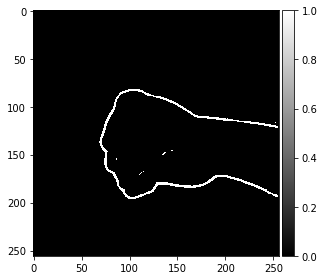

In [8]:
img = io.imread("./drive/MyDrive/img_PF/JPEG/Rock/Img/Rock0.jpg")
img_mask = io.imread("./drive/MyDrive/img_PF/JPEG/Rock/Mask/Rock0_Mask.jpg")
img_mask = (img_mask-np.min(img_mask))/(np.max(img_mask)-np.min(img_mask))
img_sobel = filters.sobel(img)
thresh_otsu = threshold_otsu(img_sobel)
border = segmentation_thresh(img_sobel, thresh_otsu)
cross = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
border = binary_closing(border, cross).astype(int)

perimetro = border[border == 1].shape[0]
params = calc_region_params(img, img_mask, perimetro)

print(params)
io.imshow(border, cmap="gray")

In [9]:
def plot_boundaries(model,X_train,y_train):
#Based on https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

  cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
  cmap_bold = ["darkorange", "c", "darkblue"]

  h = 0.01  # step size in the mesh
  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
  y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(8, 6))
  plt.contourf(xx, yy, Z, cmap=cmap_light)

  # Plot also the training points
  sns.scatterplot(
      x=X_train[:, 0],
      y=X_train[:, 1],
      hue=y_train,
      palette=cmap_bold,
      alpha=1.0,
      edgecolor="black",
  )
  plt.show()

  return None

In [10]:
# def plot_boundaries(model,X_train,y_train):
# #Based on https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

#   cmap_light = ListedColormap(["orange", "cyan"])
#   cmap_bold = ["darkorange", "c"]

#   h = 0.01  # step size in the mesh
#   # Plot the decision boundary. For that, we will assign a color to each
#   # point in the mesh [x_min, x_max]x[y_min, y_max].
#   x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
#   y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
#   xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#   Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

#   # Put the result into a color plot
#   Z = Z.reshape(xx.shape)
#   plt.figure(figsize=(8, 6))
#   plt.contourf(xx, yy, Z, cmap=cmap_light)

#   # Plot also the training points
#   sns.scatterplot(
#     x=X_train[:, 0],
#     y=X_train[:, 1],
#     hue = y_train,
#   )
#   plt.show()

#   return None

In [11]:
csv_data = pd.read_csv('./drive/MyDrive/img_PF/parameters.csv')

In [12]:
def create_Xy(dataFrame,fCol_start,fCol_end):

  #dataFrame: Dataframe con características y etiquetas
  #fCol_start: Índice de la columna donde comienzan las características
  #fCol_end: Índice de la columna donde terminan las características

  dataFrame_np = np.array(dataFrame) #Transforma el dataframe en un numpy array para que trabajemos con el tipo de dato con el que ya estamos familiarizados.
  
  X = dataFrame_np[:, fCol_start : fCol_end+1]
  
  # X = np.delete(X, 1, 1)
  # X = np.delete(X, 3, 1)
  # X = np.delete(X, 1, 1)

  y = dataFrame_np[:,-1]

  # y[y==2] = 1
  y = y.astype(int).ravel()
  
  return X,y

fCol_start = 3
fCol_end = 4

X, y = create_Xy(csv_data,fCol_start,fCol_end)

In [13]:
print(X)

[[7.05582440e-01 5.97073853e-01]
 [5.57727456e-01 7.36203134e-01]
 [5.36166728e-01 6.31383717e-01]
 [7.15137124e-01 6.12526774e-01]
 [6.71064496e-01 6.35486305e-01]
 [7.10317850e-01 5.93521416e-01]
 [7.24665880e-01 6.13968909e-01]
 [5.96743226e-01 6.92344844e-01]
 [6.74568534e-01 5.88511884e-01]
 [9.90247011e-01 7.19246209e-01]
 [9.24661756e-01 6.22562468e-01]
 [7.79944479e-01 9.45962012e-01]
 [7.36333370e-01 9.18077886e-01]
 [7.34918416e-01 9.58047748e-01]
 [8.24921787e-01 8.44069481e-01]
 [7.69322693e-01 7.92852640e-01]
 [8.37026000e-01 8.09149921e-01]
 [8.19493771e-01 8.79562557e-01]
 [6.77087486e-01 8.65153611e-01]
 [8.06073546e-01 7.91684568e-01]
 [6.94749415e-01 7.47849345e-01]
 [7.23020792e-01 7.91884482e-01]
 [6.90011322e-01 8.36660087e-01]
 [6.11739397e-01 8.26840699e-01]
 [8.36736619e-01 7.98181355e-01]
 [6.76048219e-01 7.83583283e-01]
 [7.67960846e-01 8.30091953e-01]
 [7.25594521e-01 8.10811520e-01]
 [7.98584104e-01 6.01814985e-01]
 [7.67611325e-01 6.66422963e-01]
 [4.608803

In [14]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


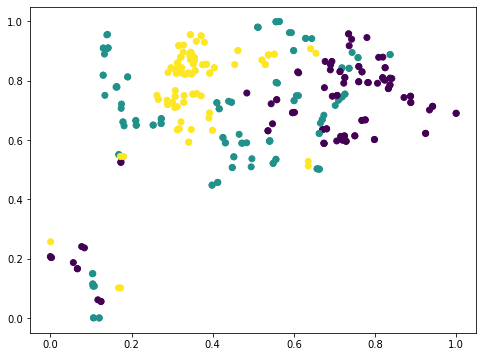

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0], X_train[:,1], c = y_train)

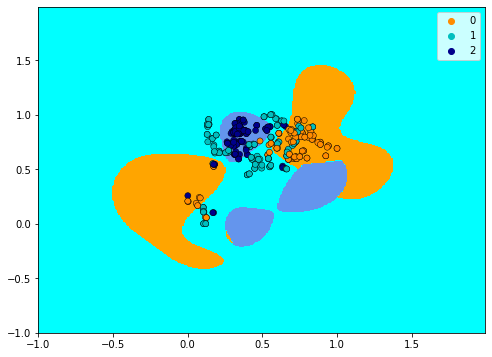

In [16]:
from sklearn.svm import SVC
v_model = SVC(C=10)
v_model = v_model.fit(X_train, y_train)
plot_boundaries(v_model, X_train, y_train)

In [17]:
y_pred_v = v_model.predict(X_test)
fs_v = f1_score(y_test, y_pred_v, average=None)

print(f"Fscore_Piedra_SVC: {fs_v[0]:.5f}")
print(f"Fscore_Papel_SVC: {fs_v[1]:.5f}")
print(f"Fscore_Tijera_SVC: {fs_v[2]:.5f}")

Fscore_Piedra_SVC: 0.80992
Fscore_Papel_SVC: 0.65672
Fscore_Tijera_SVC: 0.86000


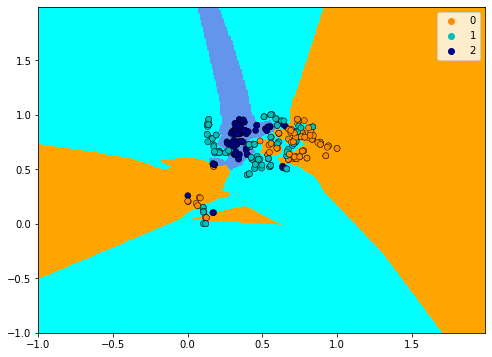

In [18]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors_5 = KNeighborsClassifier(5)
train_5 = k_neighbors_5.fit(X_train, y_train)
plot_boundaries(train_5, X_train, y_train)

In [19]:
y_pred_5 = train_5.predict(X_test)
fs_5 = f1_score(y_test, y_pred_5, average=None)

print(f"Fscore_Piedra_KN: {fs_5[0]:.5f}")
print(f"Fscore_Papel_KN: {fs_5[1]:.5f}")
print(f"Fscore_Tijera_KN: {fs_5[2]:.5f}")

Fscore_Piedra_KN: 0.87931
Fscore_Papel_KN: 0.85714
Fscore_Tijera_KN: 0.88421


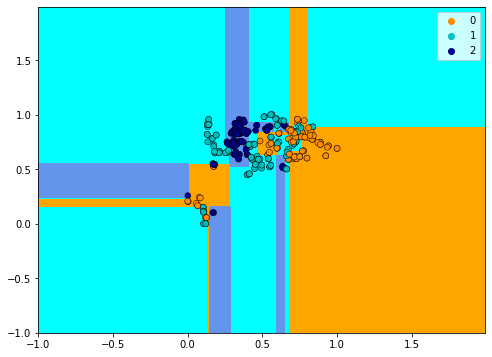

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
tree_model = DecisionTreeClassifier()
tree_model = tree_model.fit(X_train, y_train)
plot_boundaries(tree_model, X_train, y_train)

In [21]:
y_pred = tree_model.predict(X_test)
fs_tree = f1_score(y_test, y_pred, average=None)

print(f"Fscore_Piedra_tree: {fs_tree[0]:.5f}")
print(f"Fscore_Papel_tree: {fs_tree[1]:.5f}")
print(f"Fscore_Tijera_tree: {fs_tree[2]:.5f}")

Fscore_Piedra_tree: 0.94545
Fscore_Papel_tree: 0.91667
Fscore_Tijera_tree: 1.00000


In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [23]:
def create_dataset_for_ia():
  
  data_size = len(os.listdir(directories[0])) * len(directories)

  print(data_size)
  
  X = np.zeros([data_size, 256, 256])
  y = np.zeros(data_size)

  number = 0
  for i, direct in enumerate(directories):
    for index, filename in enumerate(os.listdir(direct)):

      if "Rock" in filename:
        file_type = 0 #"Rock"
      elif "Paper" in filename:
        file_type = 1 #"Paper"
      else:
        file_type = 2 #"Scissors"

      open_img_name = direct + filename

      img = io.imread(open_img_name)
      img = (img-np.min(img))/(np.max(img)-np.min(img))

      X[number, :, :] = img
      y[number] = file_type

      number += 1  
  return X, y

In [24]:
X, y = create_dataset_for_ia()

480


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
print(np.shape(X_train))

(336, 256, 256)


In [27]:
print(y_train)

[2. 0. 0. 1. 1. 0. 1. 1. 0. 0. 2. 0. 0. 0. 2. 0. 0. 1. 2. 0. 2. 2. 1. 1.
 1. 2. 0. 2. 0. 1. 1. 2. 1. 1. 0. 1. 0. 1. 0. 2. 2. 0. 2. 1. 2. 1. 0. 1.
 2. 1. 0. 1. 2. 2. 2. 1. 2. 2. 2. 2. 0. 1. 0. 2. 1. 1. 1. 0. 0. 1. 2. 0.
 2. 2. 0. 0. 1. 2. 1. 1. 0. 2. 0. 0. 0. 2. 1. 2. 1. 1. 1. 1. 2. 1. 0. 0.
 1. 1. 0. 0. 0. 2. 0. 2. 0. 2. 0. 0. 1. 2. 2. 1. 0. 2. 0. 1. 1. 1. 1. 1.
 2. 1. 2. 2. 0. 1. 1. 2. 1. 0. 2. 1. 1. 2. 1. 2. 2. 2. 2. 0. 1. 1. 2. 1.
 2. 2. 1. 2. 1. 0. 1. 1. 1. 0. 0. 2. 1. 2. 2. 0. 1. 2. 0. 2. 1. 0. 2. 0.
 2. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 2. 2. 1. 0. 0. 1. 2. 2. 1. 0. 2. 1.
 1. 1. 2. 0. 1. 2. 0. 1. 2. 1. 1. 0. 1. 1. 0. 0. 0. 1. 2. 1. 2. 0. 2. 1.
 1. 1. 1. 2. 0. 0. 0. 0. 2. 0. 2. 2. 0. 1. 0. 0. 0. 2. 2. 1. 1. 2. 2. 2.
 1. 1. 1. 1. 2. 1. 2. 2. 1. 2. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 2. 0. 2. 2.
 0. 0. 1. 0. 1. 2. 0. 2. 2. 0. 2. 1. 1. 0. 1. 0. 2. 1. 1. 2. 2. 0. 1. 2.
 1. 1. 0. 2. 0. 1. 1. 2. 1. 1. 0. 0. 2. 1. 1. 0. 1. 1. 1. 2. 1. 2. 1. 2.
 2. 1. 1. 0. 0. 0. 2. 0. 2. 0. 2. 2. 1. 2. 0. 2. 0.

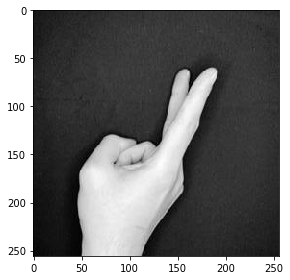

In [28]:
io.imshow(X_train[0,:,:])

In [29]:
print(y_train[0])

2.0


In [30]:
x_train = X_train[:,:,:,np.newaxis]
x_test = X_test[:,:,:,np.newaxis]

In [31]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [32]:
np.unique(y_train)

array([0., 1., 2.])

In [33]:
y_train_vec = keras.utils.to_categorical(y_train, num_classes = 3)
y_test_vec = keras.utils.to_categorical(y_test, num_classes=3)

In [34]:
print(y_train[0])
print(y_train_vec[0,:])
print(np.shape(y_train_vec))

2.0
[0. 0. 1.]
(336, 3)


In [35]:
#Comencemos definiendo ei input layer
inputs = keras.Input((256,256,1)) #Aquí ponemos las dimensiones de una de las imágenes
#Comencemos con una capa convolucional
x1 = layers.Conv2D(16,kernel_size=(3,3),activation = "relu",padding="same")(inputs)
x1 = layers.MaxPooling2D(pool_size=(2, 2))(x1)

x2 = layers.Conv2D(32,kernel_size=(3,3),activation = "relu",padding="same")(x1)
x2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)

x2 = layers.Flatten()(x2)

x3 = layers.Dense(32,activation = "relu")(x2)

outputs = layers.Dense(3,activation = "softmax")(x3)

modelMNIST = keras.Model(inputs=inputs,outputs=outputs) #Instanciemos nuestro modelo
modelMNIST.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe495b24890>>

In [36]:
modelMNIST.compile(loss="categorical_crossentropy", optimizer="adam",metrics=[keras.metrics.Precision(),keras.metrics.Recall()])

In [40]:
modelMNIST.fit(x=x_train, y=y_train_vec, epochs = 75, batch_size = 2000)

Epoch 1/75
1/1 [==============================] - 1s 818ms/step - loss: 3.0062 - precision: 0.3720 - recall: 0.3720
Epoch 2/75
1/1 [==============================] - 1s 707ms/step - loss: 3.5311 - precision: 0.3262 - recall: 0.3185
Epoch 3/75
1/1 [==============================] - 1s 746ms/step - loss: 1.0583 - precision: 0.6331 - recall: 0.4673
Epoch 4/75
1/1 [==============================] - 1s 713ms/step - loss: 2.1325 - precision: 0.3095 - recall: 0.3095
Epoch 5/75
1/1 [==============================] - 1s 731ms/step - loss: 1.6869 - precision: 0.3260 - recall: 0.3095
Epoch 6/75
1/1 [==============================] - 1s 700ms/step - loss: 1.3228 - precision: 0.4241 - recall: 0.3988
Epoch 7/75
1/1 [==============================] - 1s 736ms/step - loss: 1.1224 - precision: 0.4112 - recall: 0.3720
Epoch 8/75
1/1 [==============================] - 1s 735ms/step - loss: 0.9678 - precision: 0.5581 - recall: 0.2857
Epoch 9/75
1/1 [==============================] - 1s 742ms/step - loss: 

In [41]:
score = modelMNIST.evaluate(x_test, y_test_vec, verbose=0)
print("Test loss:", score[0])
print("Precision:", score[1])
print("Recall:", score[2])

Test loss: 0.8172851800918579
Precision: 0.8156028389930725
Recall: 0.7986111044883728


[[ True False False]]


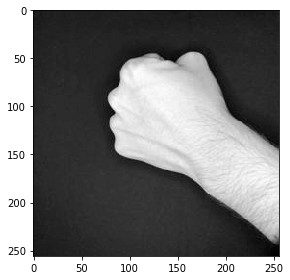

In [42]:
test1 = x_test[8,:,:,:]
np.shape(test1)
test = test1[np.newaxis,:,:,:]
np.shape(test)

print(modelMNIST.predict(test)>0.5)

io.imshow(test1[:,:,0],cmap = "gray")

[[False  True False]]


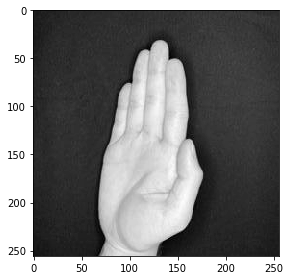

In [46]:
test1 = x_test[6,:,:,:]
np.shape(test1)
test = test1[np.newaxis,:,:,:]
np.shape(test)

print(modelMNIST.predict(test)>0.5)

io.imshow(test1[:,:,0],cmap = "gray")

[[False False  True]]


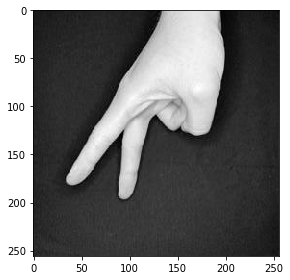

In [44]:
test1 = x_test[1,:,:,:]
np.shape(test1)
test = test1[np.newaxis,:,:,:]
np.shape(test)

print(modelMNIST.predict(test)>0.5)

io.imshow(test1[:,:,0],cmap = "gray")

In [ ]:
# modelMNIST.save('./drive/MyDrive/img_PF/my_model')

In [ ]:
new_model = tf.keras.models.load_model('./drive/MyDrive/img_PF/my_model')

# Check its architecture
new_model.summary()

In [ ]:
loss, acc, rec = new_model.evaluate(x_test, y_test_vec, verbose=0)
print(f'Restored model, accuracy: {(100*acc):.2f}%')

print(new_model.predict(x_test).shape)